## Objectives of this notebook
The goal of this notebook is to demonstrate SimCLR using pytorch. The notebook is based on the code in the tutorial with some minor changes to demonstrate the functioning better.

### Contrastive Learning 
Simply put contrastive learning refers to a technique of self-supervised learning that creates representations such that similarities between samples are captured as located closely in the space while dissimilar samples are pushed apart.  

## Preliminary Steps

### Dataset
To demonstrate the algorithm, we are using a sample of the imagenet dataset with 5 categories being represented.

In [1]:
# Getting the dataset from the github repo of imagenet 5 categories
!git clone https://github.com/thunderInfy/imagenet-5-categories.git

fatal: destination path 'imagenet-5-categories' already exists and is not an empty directory.


In [2]:
# Some useful imports to get resnet SimCLR results folder
import requests
import zipfile
import io

In [3]:
# Getting simCLR results folder
r = requests.get('https://github.com/thunderInfy/resnet-simclr/blob/master/results.zip?raw=true')
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()   

In [4]:
# Useful imports

import numpy as np
import torch
from torchvision import transforms as T
from torchsummary import summary
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet18

import os
from PIL import Image
from collections import OrderedDict

import random

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
tsne = TSNE()

### GPU Configuration

In [5]:
# device is set to cuda if cuda is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()

# root folder is the name of the folder where data is contained
root_folder = 'imagenet-5-categories'

train_names = sorted(os.listdir(root_folder + '/train'))
test_names = sorted(os.listdir(root_folder + '/test'))

# setting random seed to ensure the same 10% labelled data is used when training the linear classifier
random.seed(0)

names_train_10_percent = random.sample(train_names, len(train_names) // 10)
names_train = random.sample(train_names, len(train_names))
names_test = random.sample(test_names, len(test_names))

### Label Mapping
We have 5 classes, a mapping is created betweeen class names and the label numbers used along side the files. Because this is a self-supervised learning technique, the labels are of no-use during training. 

In [6]:
# defining a mapping between class names and numbers
mapping = {'car': 0, 'dog': 1, 'elephant': 2, 'cat': 3, 'airplane': 4}
inverse_mapping = ['car', 'dog', 'elephant', 'cat', 'airplane']

# getting labels based on filenames, note that the filenames themselves contain classnames
# also note that these labels won't be used to actually train the base model
# these are just for visualization purposes
labels_train = [mapping[x.split('_')[0]] for x in names_train]
labels_test = [mapping[x.split('_')[0]] for x in names_test]

# these 10 percent labels will be used for training the linear classifer
labels_train_10_percent = [mapping[x.split('_')[0]] for x in names_train_10_percent]

# Data augmentation
In case of SimCLR, the data that is available is augmented by creating multiple versions of the same image - in our case we distort the color to create alternate versions. This forms the postive pairs that will allow us to learn similarity while any of the other images are dissimilar. 

In [7]:
# A function to perform color distortion in images
# It is used in SimCLR alongwith random resized cropping
# Here, s is the strength of color distortion.

def get_color_distortion(s=1.0):
    color_jitter = T.ColorJitter(0.8 * s, 0.8 * s, 0.8 * s, 0.2 * s)
    rnd_color_jitter = T.RandomApply([color_jitter], p=0.8)
    
    # p is the probability of grayscale, here 0.2
    rnd_gray = T.RandomGrayscale(p=0.2)
    color_distort = T.Compose([rnd_color_jitter, rnd_gray])
    
    return color_distort

In [8]:
# this is the dataset class

class MyDataset(Dataset):
    def __init__(self, root_dir, filenames, labels, mutation=False):
        self.root_dir = root_dir
        self.file_names = filenames
        self.labels = labels
        self.mutation = mutation

    def __len__(self):
        return len(self.file_names)

    def tensorify(self, img):
        res = T.ToTensor()(img)
        res = T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))(res)
        return res

    def mutate_image(self, img):
        res = T.RandomResizedCrop(224)(img)
        res = get_color_distortion(1)(res)
        return res

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.file_names[idx])
        image = Image.open(img_name)
        label = self.labels[idx]
        image = T.Resize((250, 250))(image)

        if self.mutation:
            image1 = self.mutate_image(image)
            image1 = self.tensorify(image1)
            image2 = self.mutate_image(image)
            image2 = self.tensorify(image2)
            sample = {'image1': image1, 'image2': image2, 'label': label}
        else:
            image = T.Resize((224, 224))(image)
            image = self.tensorify(image)
            sample = {'image': image, 'label': label}

        return sample

In [9]:
# datasets
training_dataset_mutated = MyDataset(root_folder + '/train', names_train, labels_train, mutation=True)
training_dataset = MyDataset(root_folder + '/train', names_train_10_percent, labels_train_10_percent, mutation=False)
testing_dataset = MyDataset(root_folder + '/test', names_test, labels_test, mutation=False)

In [10]:
# dataloaders
dataloader_training_dataset_mutated = DataLoader(training_dataset_mutated, batch_size=125, shuffle=True, num_workers=2)
dataloader_training_dataset = DataLoader(training_dataset, batch_size=75, shuffle=True, num_workers=2)
dataloader_testing_dataset = DataLoader(testing_dataset, batch_size=125, shuffle=True, num_workers=2)

In [11]:

# Afunction to get PIL image from tensor

def deprocess_and_show(img_tensor):
     return T.Compose([
             T.Normalize((0, 0, 0), (2, 2, 2)),
             T.Normalize((-0.5, -0.5, -0.5), (1, 1, 1)),
             T.ToPILImage()
           ])(img_tensor)

In [12]:
def showSampleData(dataset, imagekey):
  figure = plt.figure(figsize=(8, 8))
  cols, rows = 3, 3
  for i in range(1, cols * rows + 1):
      sample_idx = torch.randint(len(dataset), size=(1,)).item()
      img = dataset[sample_idx][imagekey]
      label = dataset[sample_idx]['label']
      figure.add_subplot(rows, cols, i)
      plt.axis("off")
      plt.title(inverse_mapping[label])
      plt.imshow(deprocess_and_show(img))
  plt.show()


## Sample Data
Below are few samples of the kind of data that is created. One is from the training dataset with the mutations and the other is from the test dataset. 

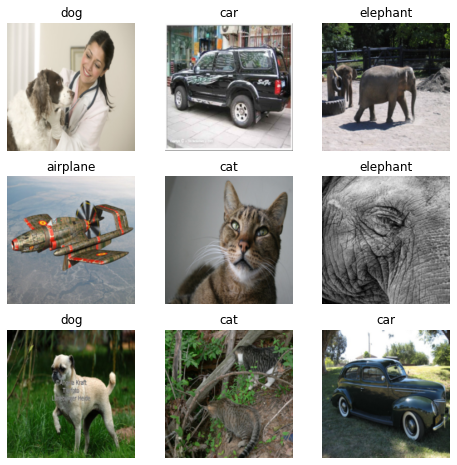

In [13]:
showSampleData(dataloader_training_dataset.dataset,'image')

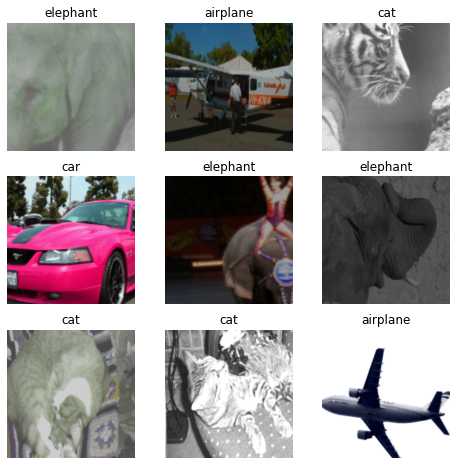

In [14]:
showSampleData(dataloader_training_dataset_mutated.dataset,'image1')

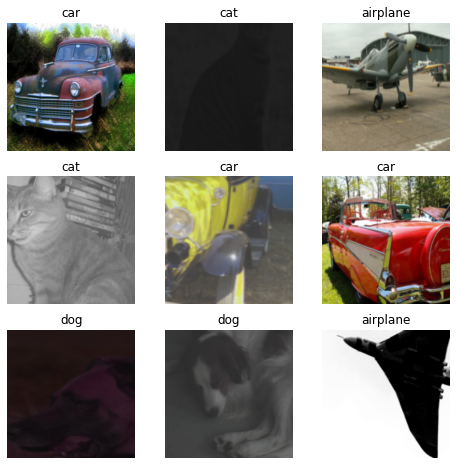

In [15]:
showSampleData(dataloader_training_dataset_mutated.dataset,'image2')

# SimCLR Architecture
The deep neural network that we are going to use is ResNet18. But the last layer is replaced with a non-linear RELU layer. 

In [16]:
# defining our deep learning architecture
resnet = resnet18(pretrained=False)

classifier = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(resnet.fc.in_features, 100)),
    ('added_relu1', nn.ReLU(inplace=True)),
    ('fc2', nn.Linear(100, 50)),
    ('added_relu2', nn.ReLU(inplace=True)),
    ('fc3', nn.Linear(50, 25))
]))

resnet.fc = classifier

The resnet and the data is moved to the CUDA device to perform the training

In [17]:
# moving the resnet architecture to device
resnet.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [18]:
summary(resnet, (3, 244, 244))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 122, 122]           9,408
       BatchNorm2d-2         [-1, 64, 122, 122]             128
              ReLU-3         [-1, 64, 122, 122]               0
         MaxPool2d-4           [-1, 64, 61, 61]               0
            Conv2d-5           [-1, 64, 61, 61]          36,864
       BatchNorm2d-6           [-1, 64, 61, 61]             128
              ReLU-7           [-1, 64, 61, 61]               0
            Conv2d-8           [-1, 64, 61, 61]          36,864
       BatchNorm2d-9           [-1, 64, 61, 61]             128
             ReLU-10           [-1, 64, 61, 61]               0
       BasicBlock-11           [-1, 64, 61, 61]               0
           Conv2d-12           [-1, 64, 61, 61]          36,864
      BatchNorm2d-13           [-1, 64, 61, 61]             128
             ReLU-14           [-1, 64,

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


## Loss Function
The loss function in our case is called NT-Xent Loss, Normalized Temperature-scaled Cross Entropy Loss. The loss is defined by the cosine similarity between all the positive pairs along with a temperature factor tau. where the numerator and the denominator is raised to exponential and a log function is applied on it. 

Reducing the overall mean loss over all the positive pairs is the goal of SimCLR

In [19]:
tau = 0.05

def loss_function(a, b):
    a_norm = torch.norm(a, dim=1).reshape(-1, 1)
    a_cap = torch.div(a, a_norm)
    b_norm = torch.norm(b, dim=1).reshape(-1, 1)
    b_cap = torch.div(b, b_norm)
    a_cap_b_cap = torch.cat([a_cap, b_cap], dim=0)
    a_cap_b_cap_transpose = torch.t(a_cap_b_cap)
    b_cap_a_cap = torch.cat([b_cap, a_cap], dim=0)
    sim = torch.mm(a_cap_b_cap, a_cap_b_cap_transpose)
    sim_by_tau = torch.div(sim, tau)
    exp_sim_by_tau = torch.exp(sim_by_tau)
    sum_of_rows = torch.sum(exp_sim_by_tau, dim=1)
    exp_sim_by_tau_diag = torch.diag(exp_sim_by_tau)
    numerators = torch.exp(torch.div(torch.nn.CosineSimilarity()(a_cap_b_cap, b_cap_a_cap), tau))
    denominators = sum_of_rows - exp_sim_by_tau_diag
    num_by_den = torch.div(numerators, denominators)
    neglog_num_by_den = -torch.log(num_by_den)
    return torch.mean(neglog_num_by_den)

In [20]:
# Defining data structures for storing training info

losses_train = []
num_epochs = 10

# using SGD optimizer
optimizer = optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)

if not os.path.exists('results'):
    os.makedirs('results')

# load pretrained model, optimizer and training losses file if model.pth file is available
if(os.path.isfile("results/model.pth")):
    resnet.load_state_dict(torch.load("results/model.pth"))
    optimizer.load_state_dict(torch.load("results/optimizer.pth"))

    for param_group in optimizer.param_groups:
        param_group['weight_decay'] = 1e-6
        param_group['lr'] = 0.000003

    temp = np.load("results/lossesfile.npz")
    losses_train = list(temp['arr_0'])

## Training
The training here is unsupervised. The trend of loss over each epoch is demonstrated below. The entire training excercise is run over 10 epochs. 

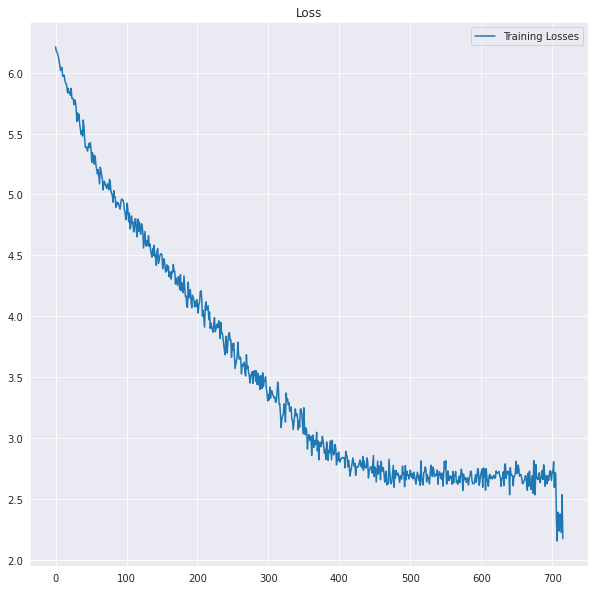

In [21]:
# Boolean variable on whether to perform training or not 
# Note that this training is unsupervised, it uses the NT-Xent Loss function

TRAINING = True

def get_mean_of_list(L):
    return sum(L) / len(L)

if TRAINING:
    # get resnet in train mode
    resnet.train()

    # run a for loop for num_epochs
    for epoch in range(num_epochs):

        # a list to store losses for each epoch
        epoch_losses_train = []

        # run a for loop for each batch
        for (_, sample_batched) in enumerate(dataloader_training_dataset_mutated):
            
            # zero out grads
            optimizer.zero_grad()

            # retrieve x1 and x2 the two image batches
            x1 = sample_batched['image1']
            x2 = sample_batched['image2']

            # move them to the device
            x1 = x1.to(device)
            x2 = x2.to(device)

            # get their outputs
            y1 = resnet(x1)
            y2 = resnet(x2)

            # get loss value
            loss = loss_function(y1, y2)
            
            # put that loss value in the epoch losses list
            epoch_losses_train.append(loss.cpu().data.item())

            # perform backprop on loss value to get gradient values
            loss.backward()

            # run the optimizer
            optimizer.step()

        # append mean of epoch losses to losses_train, essentially this will reflect mean batch loss
        losses_train.append(get_mean_of_list(epoch_losses_train))

        # Store model and optimizer files
        torch.save(resnet.state_dict(), 'results/model.pth')
        torch.save(optimizer.state_dict(), 'results/optimizer.pth')
        np.savez("results/lossesfile", np.array(losses_train))
      
# Plot the final training losses graph
fig = plt.figure(figsize=(10, 10))
sns.set_style('darkgrid')
plt.title("Loss")
plt.plot(losses_train)
plt.legend(['Training Losses'])
plt.show()

## t-SNE Visualizations
t-SNE Visualizations of the different layers showcase the formation of clusters, this indicates that the similar entities are being brought together while the dissimilar entities are pushed apart - which is the definition of loss reduction in this case - which is reducing the distance between similar entities, where the similarity is calculated by the cosine similarity function. 

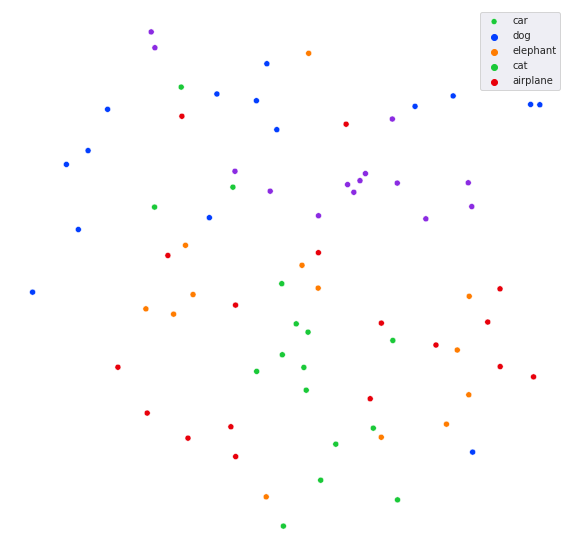

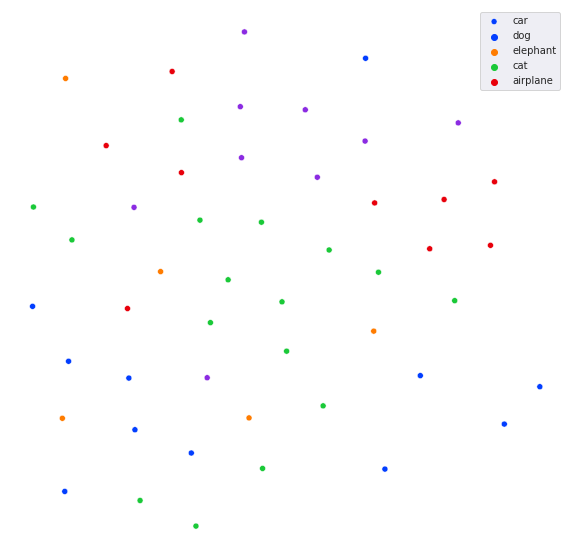

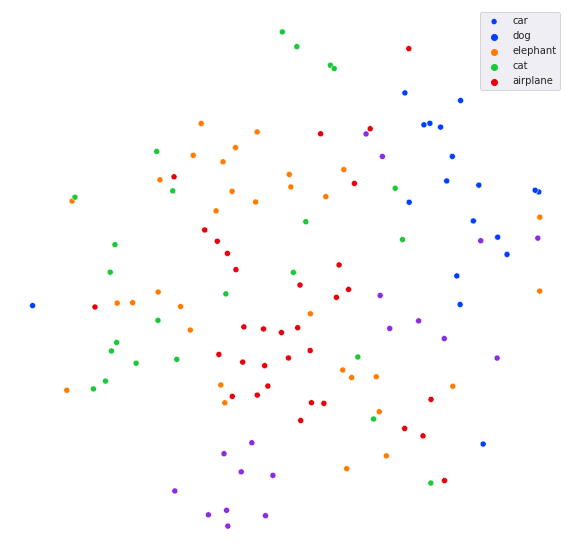

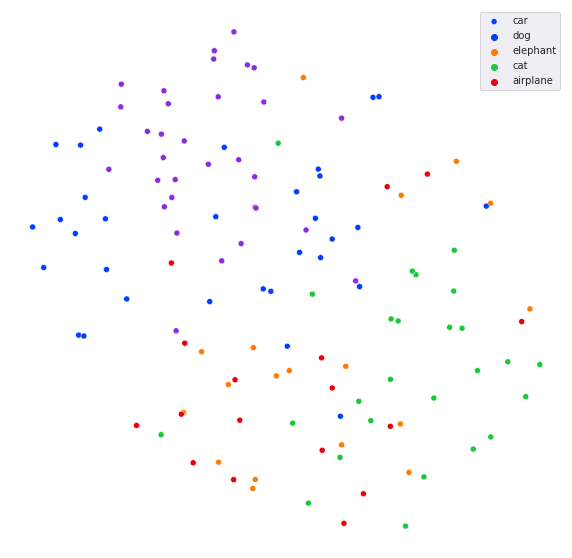

In [22]:
# a function used to plot t-SNE visualizations
def plot_vecs_n_labels(v,labels,fname):
    fig = plt.figure(figsize = (10, 10))
    plt.axis('off')
    sns.set_style("darkgrid")
    sns.scatterplot(x=v[:,0], y=v[:,1], hue=labels, legend='full', palette=sns.color_palette("bright", 5))
    plt.legend(['car', 'dog', 'elephant','cat','airplane'])
    plt.show()

# Boolean variable to control whether to perform t-SNE visualization or not
TSNEVIS = True

if TSNEVIS:
    # run resnet in eval mode
    resnet.eval()

    # get TSNE visualizations of 10% training dataset
    for (_, sample_batched) in enumerate(dataloader_training_dataset):
        x = sample_batched['image']
        x = x.to(device)
        y = resnet(x)
        y_tsne = tsne.fit_transform(y.cpu().data)
        labels = sample_batched['label']
        plot_vecs_n_labels(y_tsne,labels,'tsne_train_last_layer.png')
        x = None
        y = None
        y_tsne = None
        sample_batched = None

    # get TSNE visualizations of testing dataset
    for (_, sample_batched) in enumerate(dataloader_testing_dataset):
        x = sample_batched['image']
        x = x.to(device)
        y = resnet(x)
        y_tsne = tsne.fit_transform(y.cpu().data)
        labels = sample_batched['label']
        plot_vecs_n_labels(y_tsne,labels,'tsne_test_last_layer.png')
        x = None
        y = None
        y_tsne = None
        sample_batched = None

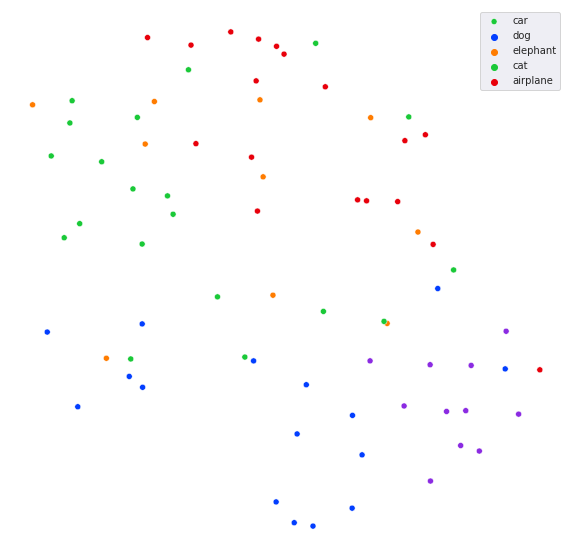

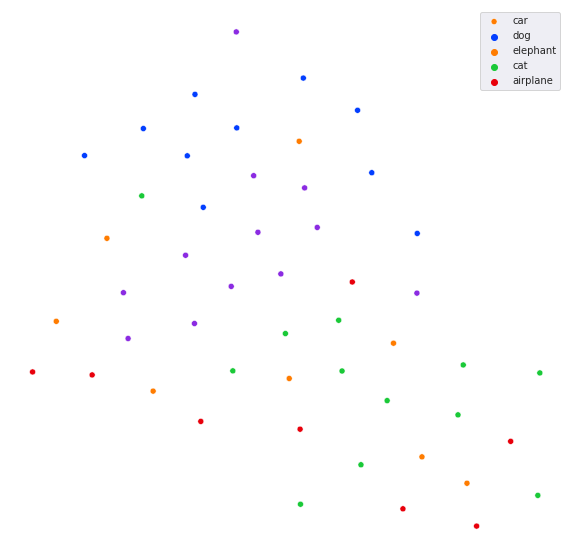

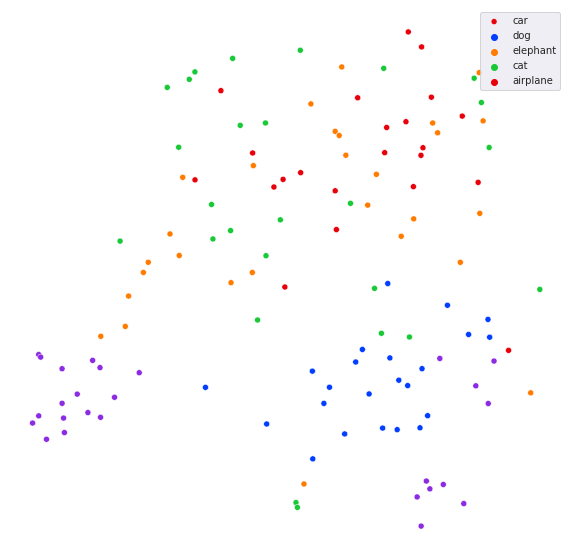

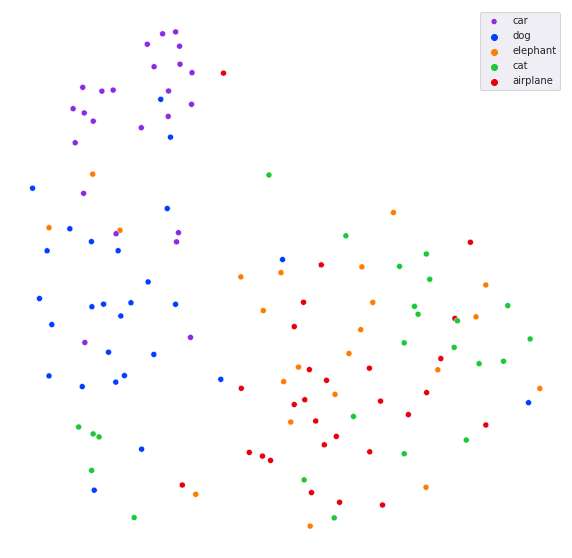

In [23]:
# Removing the last layer and the relu layer, we remove layers incrementally and look t-SNE visualizations
resnet.fc = nn.Sequential(*list(resnet.fc.children())[:-2])

if TSNEVIS:
    for (_, sample_batched) in enumerate(dataloader_training_dataset):
        x = sample_batched['image']
        x = x.to(device)
        y = resnet(x)
        y_tsne = tsne.fit_transform(y.cpu().data)
        labels = sample_batched['label']
        plot_vecs_n_labels(y_tsne,labels,'tsne_train_second_last_layer.png')
        x = None
        y = None
        y_tsne = None
        sample_batched = None

    for (_, sample_batched) in enumerate(dataloader_testing_dataset):
        x = sample_batched['image']
        x = x.to(device)
        y = resnet(x)
        y_tsne = tsne.fit_transform(y.cpu().data)
        labels = sample_batched['label']
        plot_vecs_n_labels(y_tsne,labels,'tsne_test_second_last_layer.png')
        x = None
        y = None
        y_tsne = None
        sample_batched = None


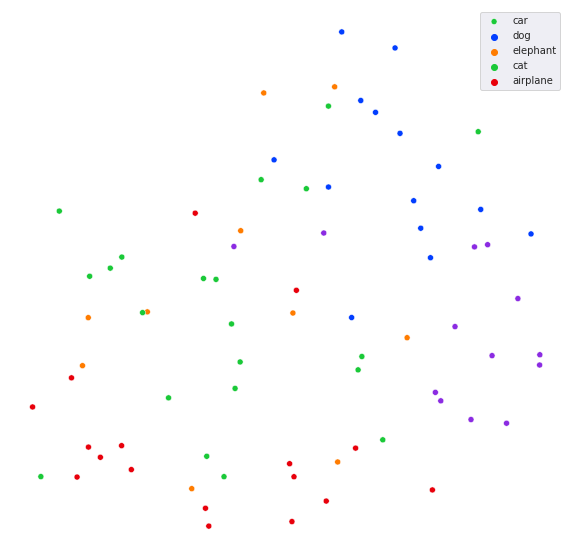

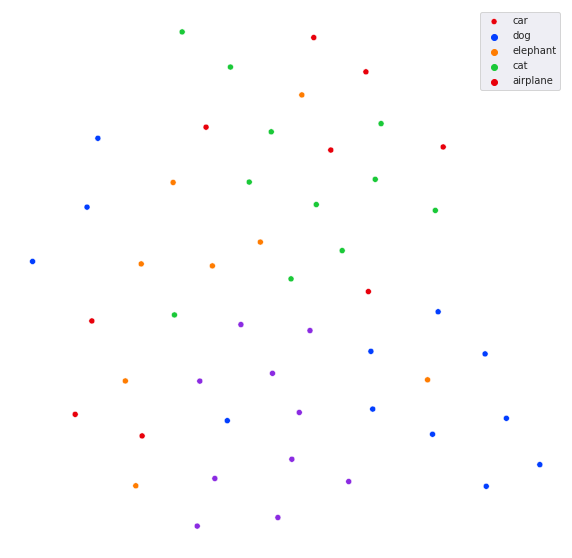

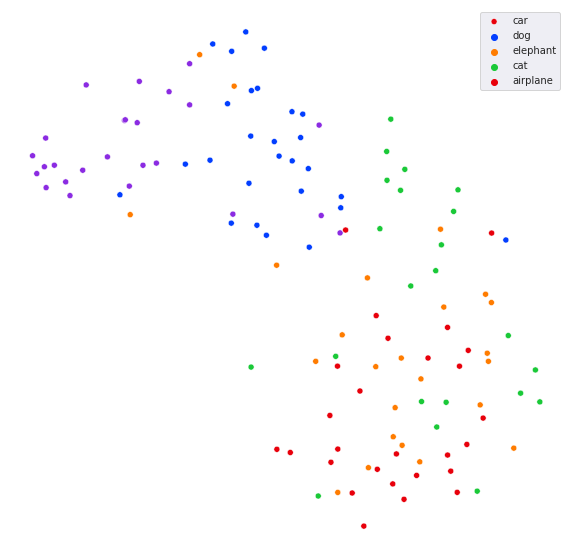

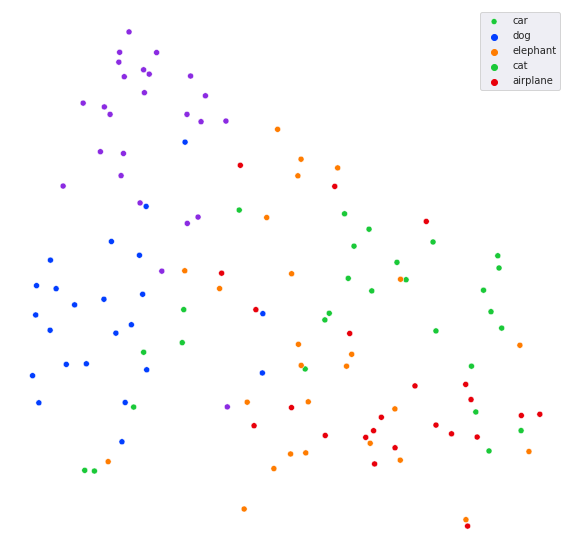

In [24]:
# removing one more layer, our entire projection head will be removed after this
resnet.fc = nn.Sequential(*list(resnet.fc.children())[:-1])

if TSNEVIS:
    for (_, sample_batched) in enumerate(dataloader_training_dataset):
        x = sample_batched['image']
        x = x.to(device)
        y = resnet(x)
        y_tsne = tsne.fit_transform(y.cpu().data)
        labels = sample_batched['label']
        plot_vecs_n_labels(y_tsne,labels,'tsne_hidden_train.png')
        x = None
        y = None
        y_tsne = None
        sample_batched = None

    for (_, sample_batched) in enumerate(dataloader_testing_dataset):
        x = sample_batched['image']
        x = x.to(device)
        y = resnet(x)
        y_tsne = tsne.fit_transform(y.cpu().data)
        labels = sample_batched['label']
        plot_vecs_n_labels(y_tsne,labels,'tsne_hidden_test.png')
        x = None
        y = None
        y_tsne = None
        sample_batched = None

# Linear Classifier for comparision
A linear classifier is trained for comparision with SimCLR, the goal is to contrast the accuracy of both the models

0.216


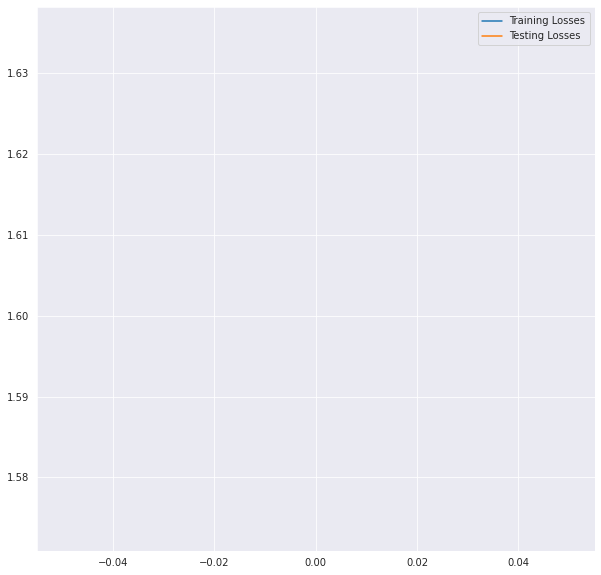

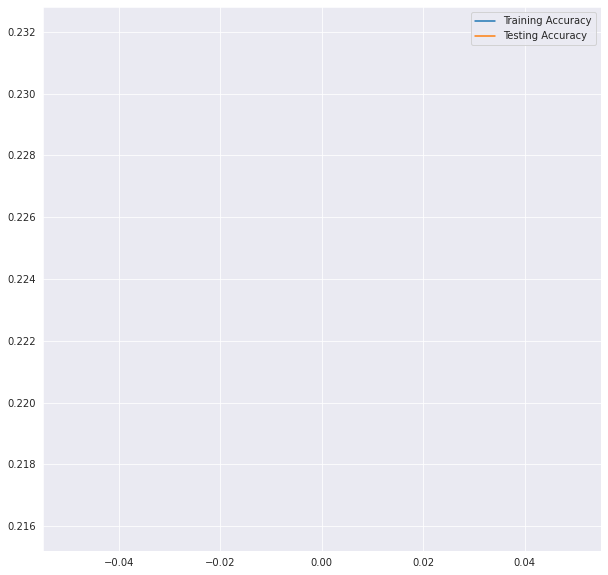

Epoch completed
0.5


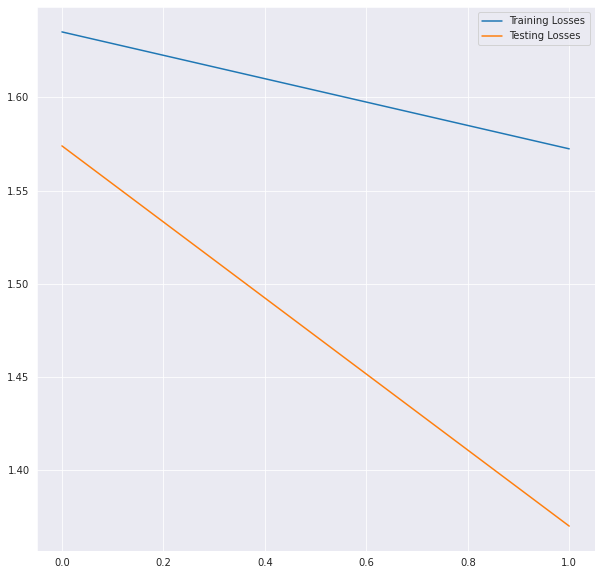

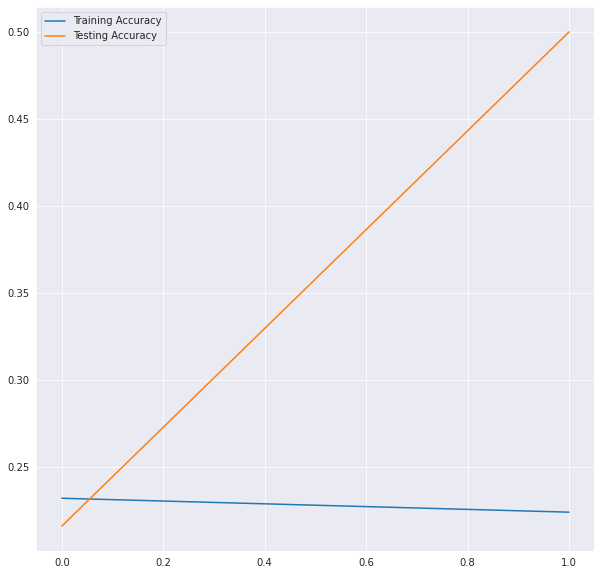

Epoch completed
0.512


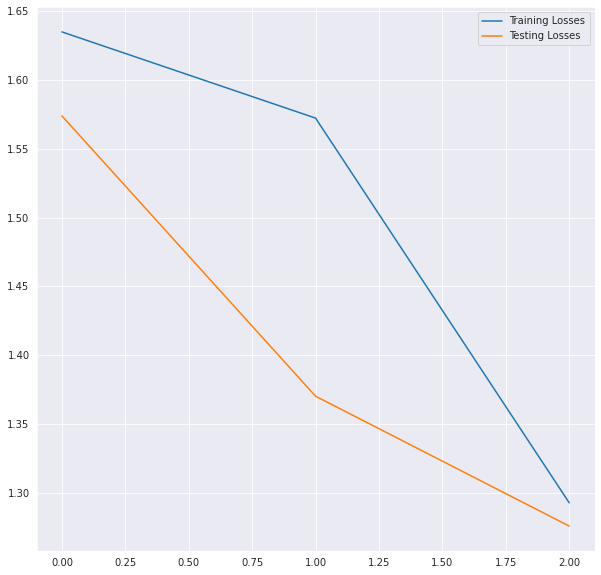

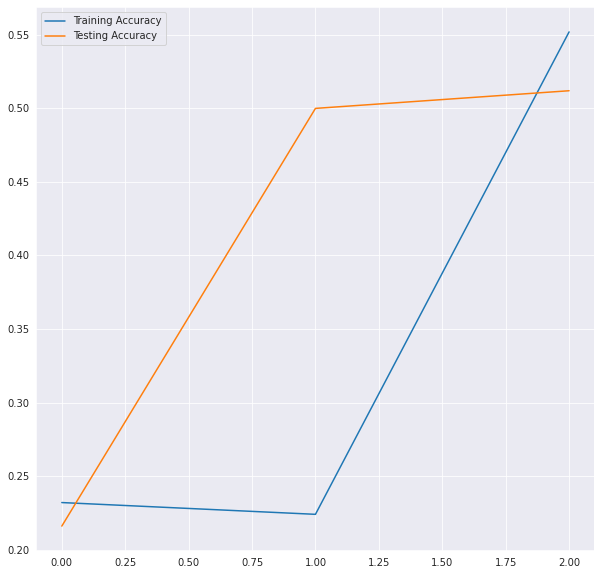

Epoch completed
0.596


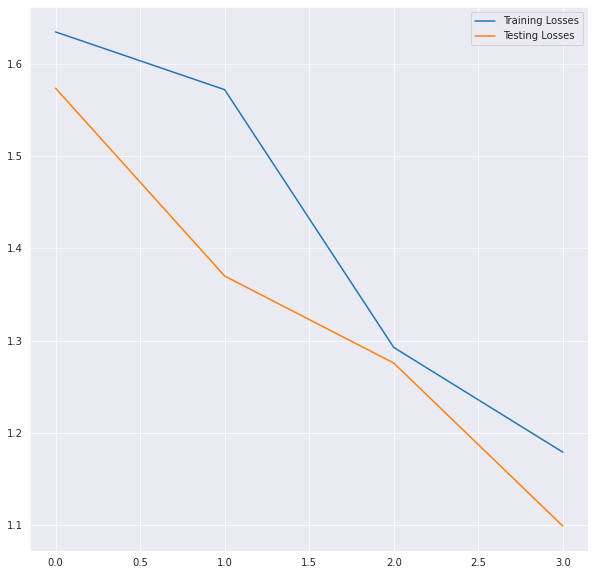

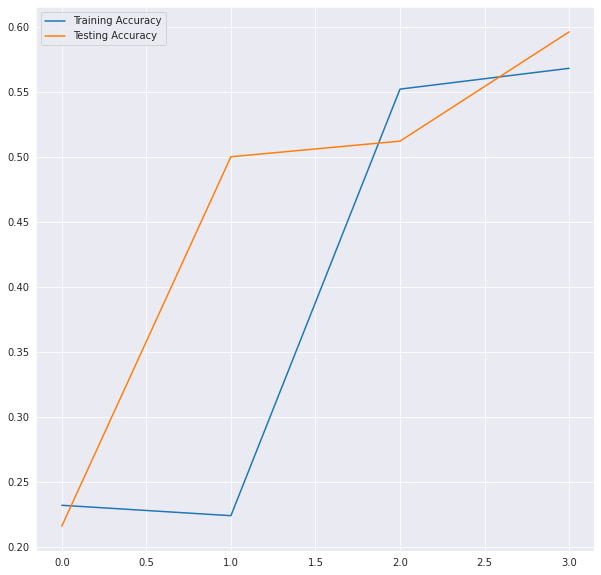

Epoch completed
0.52


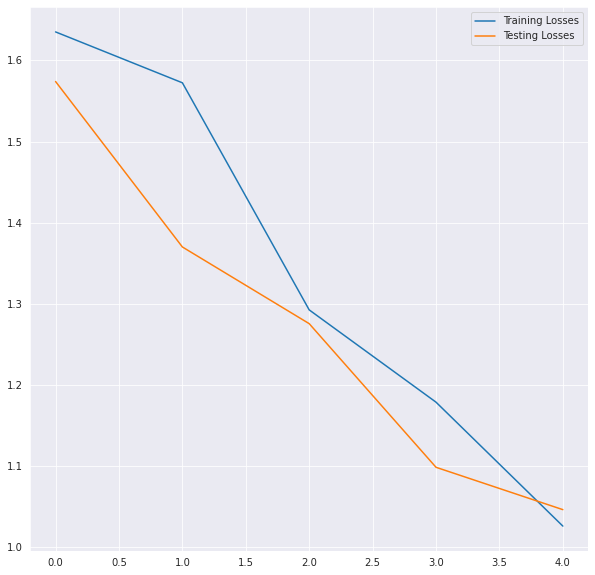

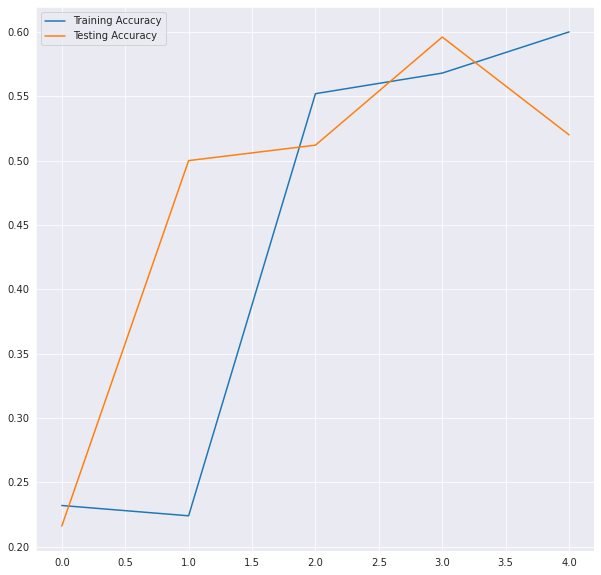

Epoch completed
0.644


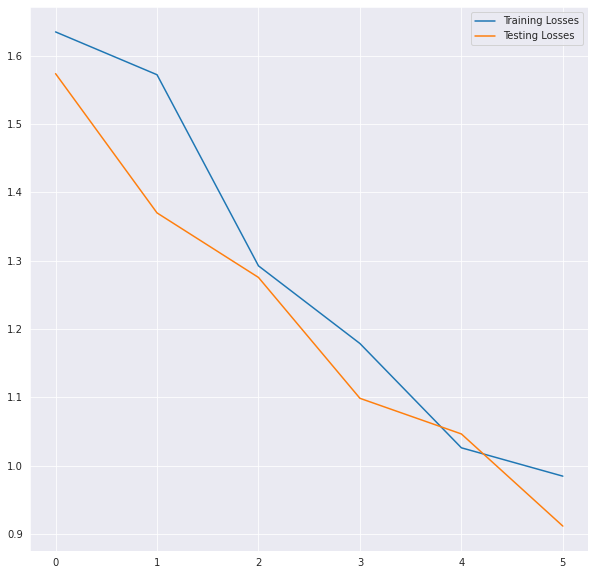

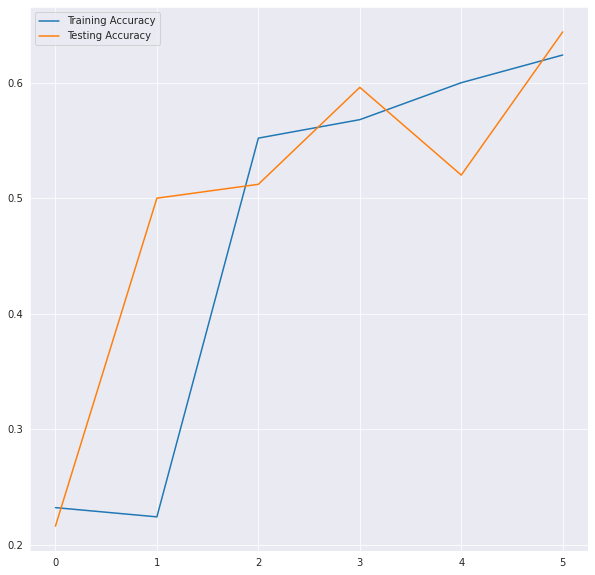

Epoch completed
0.628


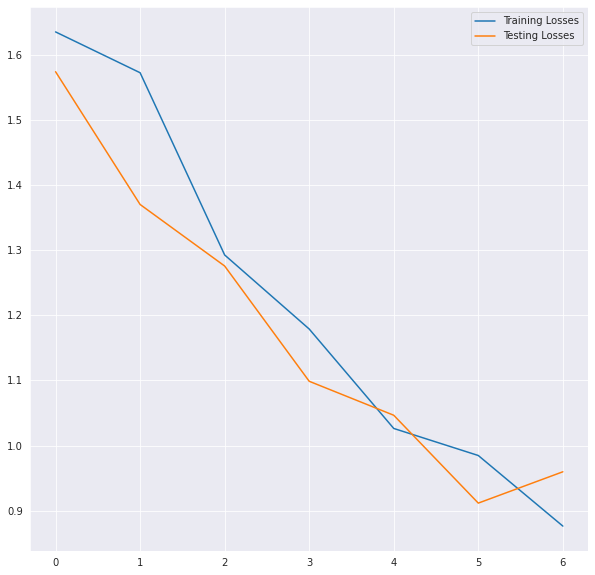

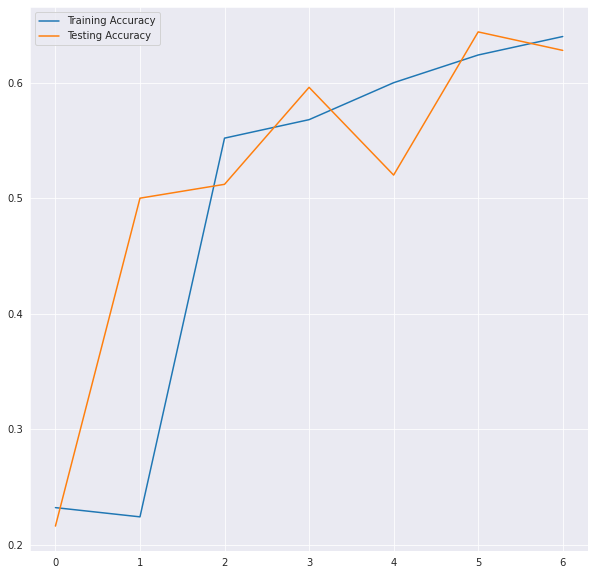

Epoch completed
0.632


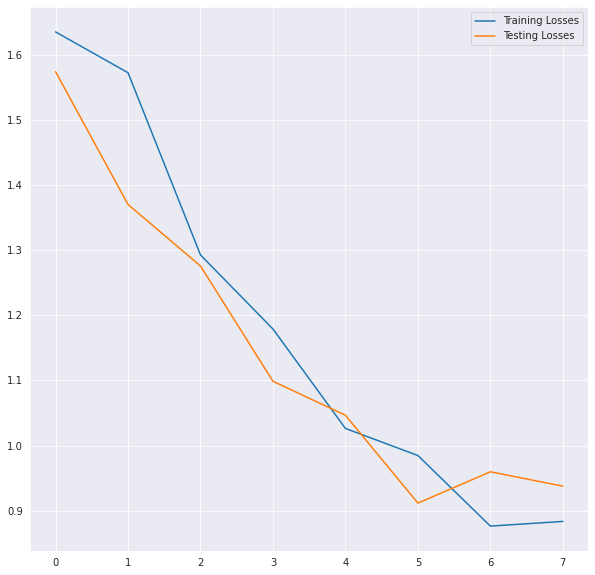

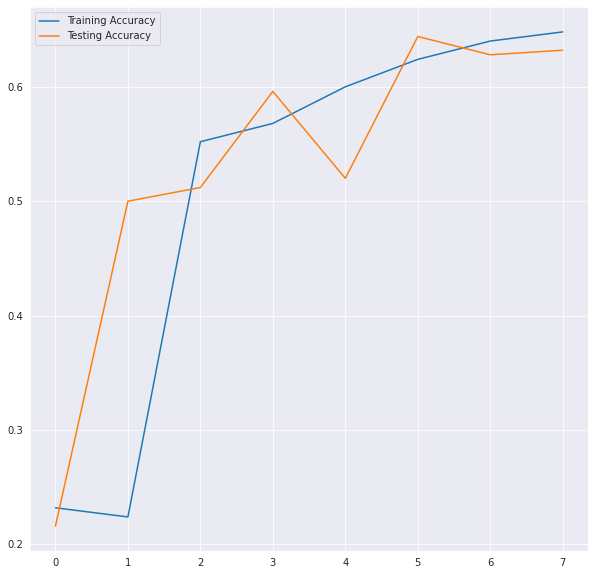

Epoch completed
0.648


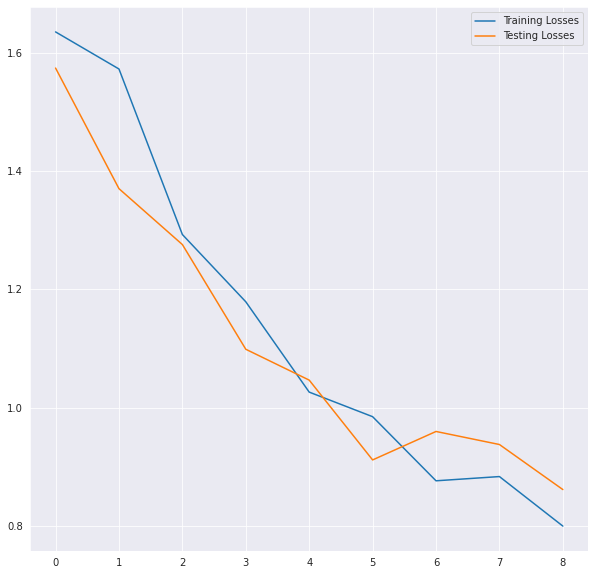

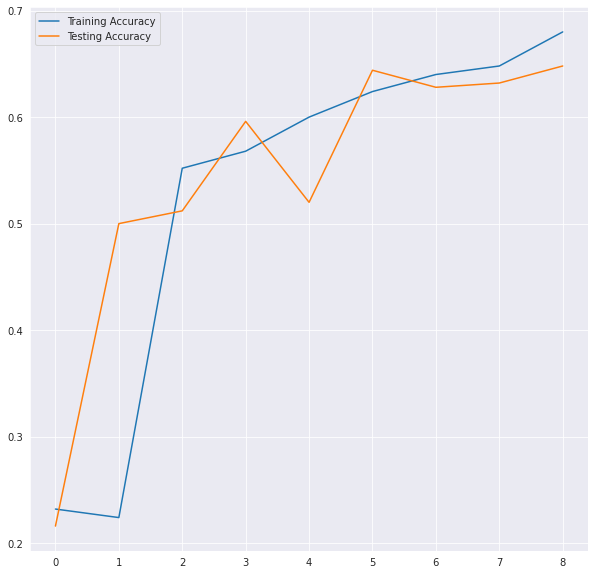

Epoch completed
0.664


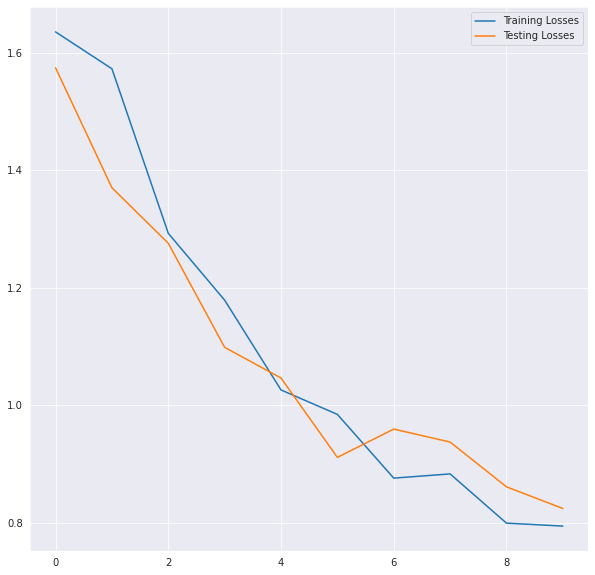

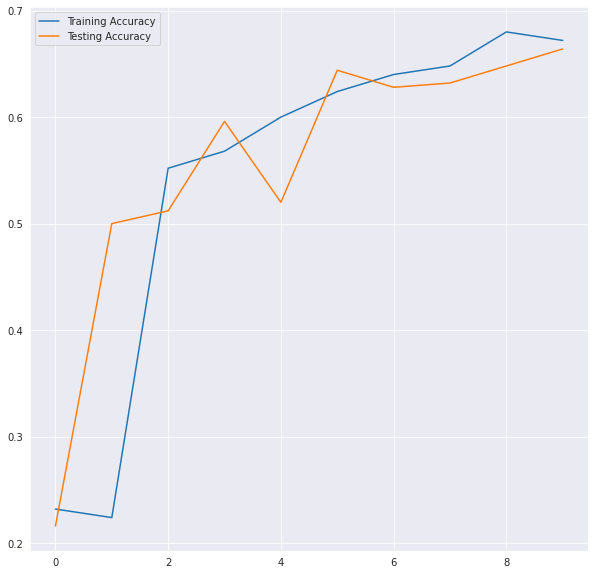

Epoch completed


In [25]:
# Boolean variable to control whether to train the linear classifier or not
LINEAR = True

class LinearNet(nn.Module):

    def __init__(self):
        super(LinearNet, self).__init__()
        self.fc1 = torch.nn.Linear(100, 5)

    def forward(self, x):
        x = self.fc1(x)
        return(x)

if LINEAR:

    if not os.path.exists('linear'):
        os.makedirs('linear')

    # getting our linear classifier
    linear_classifier = LinearNet()

    # moving it to device
    linear_classifier.to(device)

    # using SGD as a linear optimizer
    linear_optimizer = optim.SGD(linear_classifier.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-6)

    #number of epochs
    num_epochs_linear = 10

    # Boolean variable to control training of linear classifier
    LINEAR_TRAINING = True

    # Defining data structures to store train and test info for linear classifier
    losses_train_linear = []
    acc_train_linear = []
    losses_test_linear = []
    acc_test_linear = []

    # a variable to keep track of the maximum test accuracy, will be useful to store 
    # model parameters with the best test accuracy
    max_test_acc = 0

    # if a model exists in the linear folder, load it
    if(os.path.isfile("linear/model.pth")):

        # load state dict for linear model and optimizer
        linear_classifier.load_state_dict(torch.load("linear/model.pth"))
        linear_optimizer.load_state_dict(torch.load("linear/optimizer.pth"))

        # change learning rate, you can change its values if you don't feel its necessity while training
        for g in linear_optimizer.param_groups:
          g['lr'] = 0.001
          g['weight_decay'] = 0

        # load data structures
        temp = np.load("linear/linear_losses_train_file.npz")
        losses_train_linear = list(temp['arr_0'])
        temp = np.load("linear/linear_losses_test_file.npz")
        losses_test_linear = list(temp['arr_0'])
        temp = np.load("linear/linear_acc_train_file.npz")
        acc_train_linear = list(temp['arr_0'])
        temp = np.load("linear/linear_acc_test_file.npz")
        acc_test_linear = list(temp['arr_0'])

    # Run a for loop for training the linear classifier
    for epoch in range(num_epochs_linear):

        if LINEAR_TRAINING:

            # run linear classifier in train mode
            linear_classifier.train()

            # a list to store losses for each batch in an epoch
            epoch_losses_train_linear = []
            epoch_acc_train_num_linear = 0.0
            epoch_acc_train_den_linear = 0.0

            # for loop for running through each batch
            for (_, sample_batched) in enumerate(dataloader_training_dataset):

                # get x and y from the batch
                x = sample_batched['image']
                y_actual = sample_batched['label']

                # move them to the device
                x = x.to(device)
                y_actual  = y_actual.to(device)

                # get output from resnet architecture
                y_intermediate = resnet(x)

                # zero the grad values
                linear_optimizer.zero_grad()

                # run y_intermediate through the linear classifier
                y_predicted = linear_classifier(y_intermediate)

                # get the cross entropy loss value
                loss = nn.CrossEntropyLoss()(y_predicted, y_actual)

                # add the obtained loss value to this list
                epoch_losses_train_linear.append(loss.data.item())
                
                # perform backprop through the loss value
                loss.backward()

                # call the linear_optimizer step function
                linear_optimizer.step()

                # get predictions and actual values to cpu  
                pred = np.argmax(y_predicted.cpu().data, axis=1)
                actual = y_actual.cpu().data

                #update the numerators and denominators of accuracy
                epoch_acc_train_num_linear += (actual == pred).sum().item()
                epoch_acc_train_den_linear += len(actual)

                x = None
                y_intermediate = None
                y_predicted = None
                sample_batched = None

            # update losses and acc lists    
            losses_train_linear.append(get_mean_of_list(epoch_losses_train_linear))
            acc_train_linear.append(epoch_acc_train_num_linear / epoch_acc_train_den_linear)
        
        # run linear classifier in eval mode
        linear_classifier.eval()

        # essential variables to keep track of losses and acc
        epoch_losses_test_linear = []
        epoch_acc_test_num_linear = 0.0
        epoch_acc_test_den_linear = 0.0

        # run a for loop through each batch
        for (_, sample_batched) in enumerate(dataloader_testing_dataset):
            x = sample_batched['image']
            y_actual = sample_batched['label']

            x = x.to(device)
            y_actual  = y_actual.to(device)

            y_intermediate = resnet(x)

            y_predicted = linear_classifier(y_intermediate)
            loss = nn.CrossEntropyLoss()(y_predicted, y_actual)
            epoch_losses_test_linear.append(loss.data.item())

            pred = np.argmax(y_predicted.cpu().data, axis=1)
            actual = y_actual.cpu().data
            epoch_acc_test_num_linear += (actual == pred).sum().item()
            epoch_acc_test_den_linear += len(actual)

        # calculate test_acc
        test_acc = epoch_acc_test_num_linear / epoch_acc_test_den_linear
        print(test_acc)

        if LINEAR_TRAINING:
            losses_test_linear.append(get_mean_of_list(epoch_losses_test_linear))
            acc_test_linear.append(epoch_acc_test_num_linear / epoch_acc_test_den_linear)

            # plotting losses and accuracies

            fig = plt.figure(figsize=(10, 10))
            sns.set_style('darkgrid')
            plt.plot(losses_train_linear)
            plt.plot(losses_test_linear)
            plt.legend(['Training Losses', 'Testing Losses'])
            plt.show()

            fig = plt.figure(figsize=(10, 10))
            sns.set_style('darkgrid')
            plt.plot(acc_train_linear)
            plt.plot(acc_test_linear)
            plt.legend(['Training Accuracy', 'Testing Accuracy'])
            plt.show()

            print("Epoch completed")

            if test_acc >= max_test_acc:

                # save the model only when test_acc exceeds the current max_test_acc

                max_test_acc = test_acc
                torch.save(linear_classifier.state_dict(), 'linear/model.pth')
                torch.save(linear_optimizer.state_dict(), 'linear/optimizer.pth')

        # save data structures
        np.savez("linear/linear_losses_train_file", np.array(losses_train_linear))
        np.savez("linear/linear_losses_test_file", np.array(losses_test_linear))
        np.savez("linear/linear_acc_train_file", np.array(acc_train_linear))
        np.savez("linear/linear_acc_test_file", np.array(acc_test_linear))

# Conclusion
The supervised classifier shows comparable results in the current scenario when compared to SimCLR, but SimCLR does perform well with very little labeled data especially when the number of epochs is increased and the batch size is made larger. 